In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor


In [ ]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


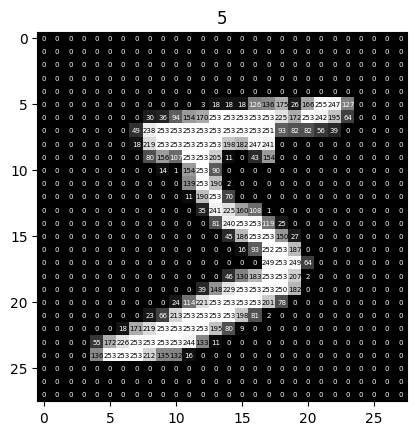

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(train_data.data[0], cmap='gray')

for i in range(train_data.data[0].shape[0]):
  for j in range(train_data.data[0].shape[1]):
    c = 1 if train_data.data[0][i, j].item() < 128 else 0
    ax.text(j, i, train_data.data[0][i, j].item(), ha='center', va='center', color=(c, c, c), fontsize=5)

plt.title('%i' % train_data.targets[0])
plt.show()

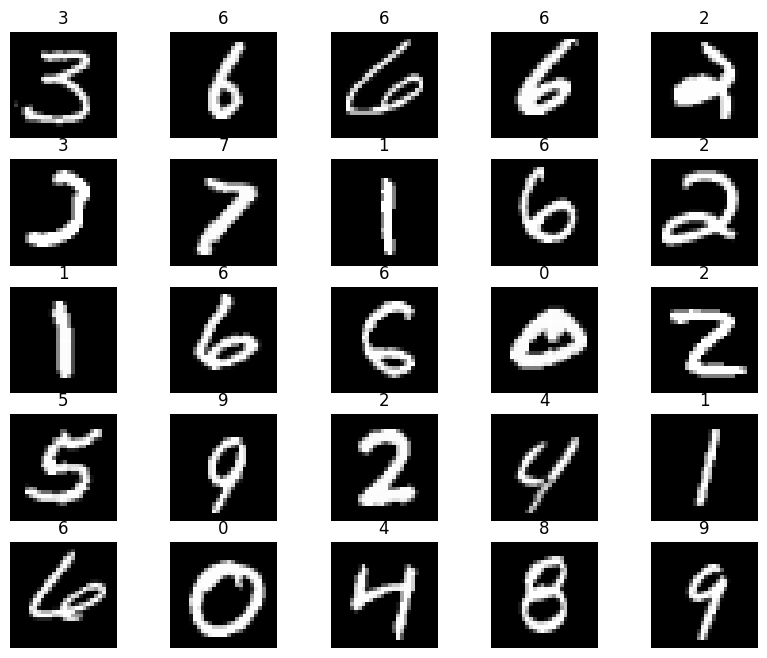

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=1)

In [ ]:
class CNN(torch.nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc = torch.nn.Linear(7*7*32, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.fc.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True  # 고정 크기 입력에서 속도 향상

Using device: cuda


In [ ]:
model = CNN().to(device)

In [ ]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.01
loss_func = torch.nn.CrossEntropyLoss()
optimzier = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
training_epochs = 10

In [ ]:
# train my model
total_batch = len(train_dataloader)

model.train()
for epoch in range(training_epochs):
  avg_cost = 0

  for X, Y in train_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    optimzier.zero_grad()
    hypothesis = model(X)
    cost = loss_func(hypothesis, Y)
    cost.backward()
    optimzier.step()

    avg_cost += cost / total_batch

  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch+1, avg_cost))

print('Learning Finished')

[Epoch:    1] cost = 0.147775367
[Epoch:    2] cost = 0.0525527224
[Epoch:    3] cost = 0.0419164114
[Epoch:    4] cost = 0.037281625
[Epoch:    5] cost = 0.0326607153
[Epoch:    6] cost = 0.0328765363
[Epoch:    7] cost = 0.0329914987
[Epoch:    8] cost = 0.0340451673
[Epoch:    9] cost = 0.0310899913
[Epoch:   10] cost = 0.0298652593
Learning Finished


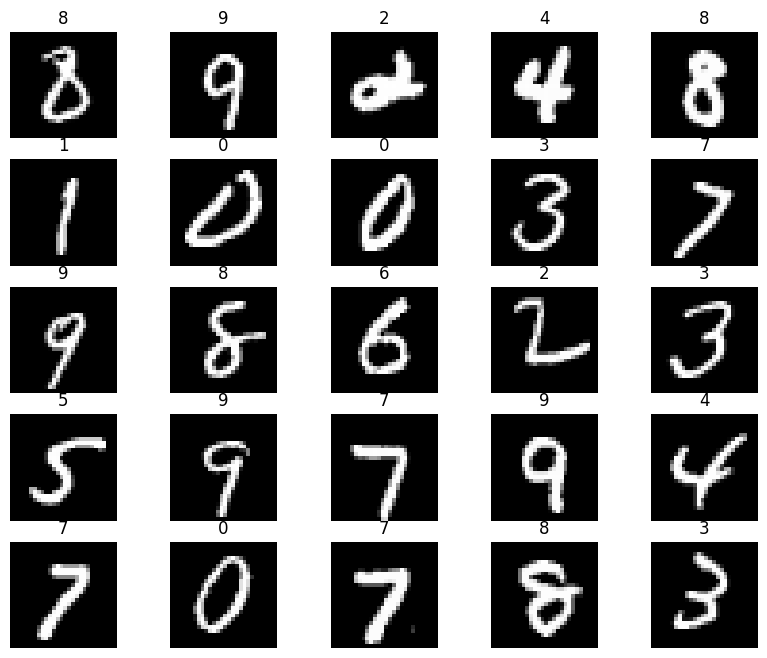

In [ ]:
model.eval()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(test_data), size=(1,)).item()
  # Move input tensor to the device
  input_tensor = torch.unsqueeze(test_dataloader.dataset[sample_idx][0], dim=0).to(device)
  test_output = model(input_tensor)
  label = torch.argmax(test_output)
  figure.add_subplot(rows, cols, i)
  plt.title(label.cpu().numpy())
  plt.axis('off')
  plt.imshow(test_dataloader.dataset[sample_idx][0].squeeze().detach().numpy(), cmap='gray')
plt.show()